# Pikachu Detector

By: Falconi Nicasio

Object detection is a classic Computer Vision problem and one of the more efficient ways to solve it is through Single Shot Detectors (SSD). The goal of this notebook is to build an SSD using a Fully Convolutional Network (FCN). This is mainly a learning exercise to understand the inner workings of an SSD network by building it from scratch using PyTorch (and MXNet). The dataset used is about 1000 images of Pikachu with bounding boxes and was found [here](https://cv.gluon.ai/build/examples_detection/finetune_detection.html) on this tutorial that uses MXNet for transfer learning. This notebook differs from that because it’s not using a pretrained network, rather it shows a custom network architecture built from scratch. Results show that even a small SSD, limited data, and a short training time of under 3-4 minutes (on GPU), it can still detect objects and draw bounding boxes with a confidence percentage of 0.64 and higher.

## Set up environment

Run the following cells to pull the code from the repository and install the requirements for this project. The `requirements.txt` file has versions of libraries from when this project was created ensuring compatability of this notebook.

In [ ]:
!git clone https://github.com/FalconiNicasio/pikachu-detector.git

Cloning into 'pikachu-detector'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 16 (delta 5), reused 11 (delta 3), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [ ]:
!pip install -r pikachu-detector/requirements.txt

     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x64802000 @  0x7f8af55da615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from skimage.transform import rescale, resize
from skimage import io
from mxnet import npx, recordio
from mxnet import np as mxnp
from mxnet.image import imdecode
import requests
from torchvision.datasets.vision import VisionDataset
from typing import Any, Callable, Optional, Tuple
import os
import hashlib
from PIL import Image
import torchvision.transforms.functional as tf
from torchsummary import summary

np.set_printoptions(2)
npx.set_np()

In [ ]:
# device config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Single Shot Multibox Detection (SSD)

## Model

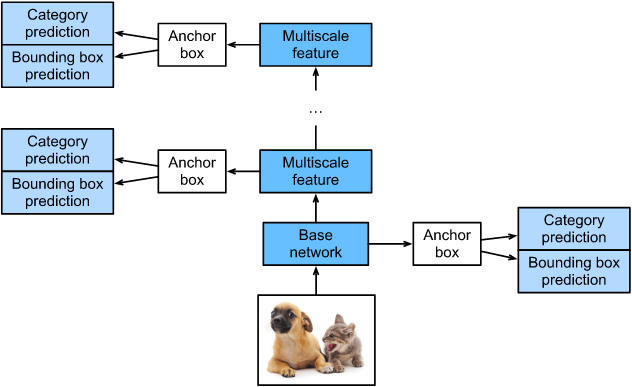

## Category Prediction Layer

In [ ]:
# category prediction layer
def cls_predictor(in_channels, num_anchors, num_classes):
    '''function for category prediction layer
    output: (batch size, number of channels, height, width)

    example: 16 batch size, 128x128 image, 5 anchors, 10 classes would produce 
    (5 * (10 + 1) = 55 channels resulting in an output of (16, 55, 128, 128))
    '''
    return nn.Conv2d(in_channels, num_anchors * (num_classes + 1), kernel_size=3, padding=1)

## Bounding Box Prediction Layer

In [ ]:
# bounding box prediction layer
def bbox_predictor(in_channels, num_anchors):
    return nn.Conv2d(in_channels, num_anchors*4, kernel_size=3, padding=1)

## Concatenating Predictions for Multiple Scales

SSD uses feature maps based on multiple scales to generate anchor boxes and predict their categories and offsets. Because the shapes and number of anchor boxes centered on the same element differ for the feature maps of different scales, the prediction outputs at different scales may have different shapes.

In [ ]:
# test
Y1 = cls_predictor(8, 5, 10)(torch.zeros((2, 8, 20, 20)))
Y2 = cls_predictor(16, 3, 10)(torch.zeros((2, 16, 10, 10)))
(Y1.shape, Y2.shape)

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [ ]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), 1, -1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [ ]:
concat_preds([Y1,Y2]).shape

torch.Size([2, 25300])

## Height and Width Downsample Block

In [ ]:
def down_sample_blk(in_channels, num_channels):
    blk = nn.Sequential()
    for i in range(2):
        blk.add_module(f'c{i}', nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
        blk.add_module(f'b{i}', nn.BatchNorm2d(num_channels, momentum=0.9))
        blk.add_module(f'r{i}', nn.ReLU())
        in_channels = num_channels
    blk.add_module('m', nn.MaxPool2d(2))
    return blk

In [ ]:
#test
down_sample_blk(3, 10)(torch.zeros((2, 3, 20, 20))).shape

torch.Size([2, 10, 10, 10])

In [ ]:
down_sample_blk(3, 10)

Sequential(
  (c0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b0): BatchNorm2d(10, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (r0): ReLU()
  (c1): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1): BatchNorm2d(10, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (r1): ReLU()
  (m): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

## Base Network Block

In [ ]:
def base_net(in_channels):
    """The base network block is used to extract features from original images. 
    To simplify the computation, we will construct a small base network. 
    This network consists of three height and width downsample blocks connected in a series, 
    so it doubles the number of channels at each step. 
    When we input an original image with the shape 256×256, 
    the base network block outputs a feature map with the shape  32×32
    """
    blk = nn.Sequential()
    for i, num_filters in enumerate([16, 32, 64]):
        blk.add_module(f'{i}', down_sample_blk(in_channels, num_filters))
        in_channels=num_filters
    return blk

In [ ]:
# test
base_net(3)(torch.zeros(2, 3, 256, 256)).shape

torch.Size([2, 64, 32, 32])

## The Complete Model


The SSD model contains a total of five modules. Each module outputs a feature map used to generate anchor boxes and predict the categories and offsets of these anchor boxes. The first module is the base network block, modules two to four are height and width downsample blocks, and the fifth module is a global maximum pooling layer that reduces the height and width to 1. Therefore, modules two to five are all multiscale feature blocks 

In [ ]:
def get_blk(i):
    if i == 0:
        blk = base_net(3)
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.MaxPool2d(4, ceil_mode=True)
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [ ]:
#TODO convert npx.multibox_prior and npx.multibox_target to PyTorch function
def to_mx(tensor):
    if tensor.device.type == 'cuda':
        arr = mxnp.array(tensor.cpu().detach().numpy())
    else:
        arr = mxnp.array(tensor.detach().numpy())
    return arr

def to_tensor(mxarr, dtype=torch.float32):
    return torch.tensor(mxarr.asnumpy(), dtype=dtype, device=device)

def get_anchors(Y, sizes, ratios):
    """npx.multibox_prior wrapper to work with PyTorch"""
    Y = to_mx(Y)
    anchors = npx.multibox_prior(Y, sizes=sizes, ratios=ratios)
    return to_tensor(anchors)

def get_target(anchors, Y, cls_preds):
    """npx.multibox_target wrapper for use with Pytorch"""
    # convert to mx numpy arrays
    anchors, cls_Y, cls_preds = to_mx(anchors), to_mx(Y), to_mx(cls_preds)
    bbox_labels, bbox_masks, cls_labels = npx.multibox_target(
                anchors, cls_Y, cls_preds)
    return to_tensor(bbox_labels), to_tensor(bbox_masks), to_tensor(cls_labels, dtype=torch.long)

# TODO convert get_detection to PyTorch function
def get_detection(cls_probs, bbox_preds, anchors):
    """npx.multibox_detection wrapper for PyTorch"""
    cls_probs, bbox_preds, anchors = to_mx(cls_probs), to_mx(bbox_preds), to_mx(anchors)
    output = npx.multibox_detection(cls_probs, bbox_preds, anchors)
    return to_tensor(output)

In [ ]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = get_anchors(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [ ]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            if i == 0:
                setattr(self, f'cls_{i}', cls_predictor(64, num_anchors, num_classes))
                setattr(self, f'bbox_{i}', bbox_predictor(64, num_anchors))
            else:
                setattr(self, f'cls_{i}', cls_predictor(128, num_anchors, num_classes))
                setattr(self, f'bbox_{i}', bbox_predictor(128, num_anchors))
    
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self, 'blk_%d' % i) accesses self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        # In the reshape function, 0 indicates that the batch size remains
        # unchanged
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds.permute(0, 2, 1), bbox_preds

We now create an SSD model instance and use it to perform forward computation on image minibatch X, which has a height and width of 512 pixels. As we verified previously, the first module outputs a feature map with the shape  32×32 . Because modules two to four are height and width downsample blocks, module five is a global pooling layer, and each element in the feature map is used as the center for 4 anchor boxes, a total of  (322+162+82+42+1)×4=5444  anchor boxes are generated for each image at the five scales.

In [ ]:
net = TinySSD(num_classes=1)
X = torch.zeros(32, 3, 256, 256)
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 2, 5444])
output bbox preds: torch.Size([32, 21776])


In [ ]:
summary(net.to(device), input_size=(3,256,256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 256, 256]             448
       BatchNorm2d-2         [32, 16, 256, 256]              32
              ReLU-3         [32, 16, 256, 256]               0
            Conv2d-4         [32, 16, 256, 256]           2,320
       BatchNorm2d-5         [32, 16, 256, 256]              32
              ReLU-6         [32, 16, 256, 256]               0
         MaxPool2d-7         [32, 16, 128, 128]               0
            Conv2d-8         [32, 32, 128, 128]           4,640
       BatchNorm2d-9         [32, 32, 128, 128]              64
             ReLU-10         [32, 32, 128, 128]               0
           Conv2d-11         [32, 32, 128, 128]           9,248
      BatchNorm2d-12         [32, 32, 128, 128]              64
             ReLU-13         [32, 32, 128, 128]               0
        MaxPool2d-14           [32, 32,

In [ ]:
# clean up
del Y1, Y2, X, anchors, cls_preds, bbox_preds, net

# Training

## Data Reading and Initialization

Class `Pikachu` is a custom PyTorch `VisionDataset` created

In [ ]:
class Pikachu(VisionDataset):
    """Pikachu Object Detection dataset <https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/>
    Args:
          root (string): Root directory of dataset where ``Pikachu/processed/training.pt``
              and  ``Pikachu/processed/test.pt`` exist.
          train (bool, optional): If True, creates dataset from ``training.pt``,
              otherwise from ``test.pt``.
          download (bool, optional): If true, downloads the dataset from the internet and
              puts it in root directory. If dataset is already downloaded, it is not
              downloaded again.
          transform (callable, optional): A function/transform that  takes in an PIL image
              and returns a transformed version. E.g, ``transforms.RandomCrop``
          target_transform (callable, optional): A function/transform that takes in the
              target and transforms it.
      """

    resources = [
      ("https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.rec", "7905cb8c93bb761a4b35698261ec794a"),
      ("https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.idx", "40702e33312e8c5f50e99fe9de18f7e7"),
      ("https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/val.rec", "dd0eee872797219f4134383501ad815f"),
      ("https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/val.idx", "b58c9768d33209afd9a929e67d379cd1")
    ]

    training_file = 'training.pt'
    test_file = 'test.pt'

    def __init__(self, root: str, train: bool=True, transform: Optional[Callable]=None, 
                target_transform: Optional[Callable]=None, download: bool=False) -> None:
        super(Pikachu, self).__init__(root, transform=transform, target_transform=target_transform)
        self.train = train

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                              ' You can use download=True to download it')
        
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple (image, target): where target is index of the target class
        """
        img, target = self.data[index], self.targets[index]

        #img = Image.fromarray(img.numpy(), mode='P')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        return len(self.data)

    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    def _check_exists(self) -> bool:
        return (os.path.exists(os.path.join(self.processed_folder,
                                            self.training_file)) and
                os.path.exists(os.path.join(self.processed_folder,
                                            self.test_file)))
        
    def download(self) -> None:
        """Download Pikachu data if it doesn't exist in processed_folder already."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)
        os.makedirs(self.processed_folder, exist_ok=True)

        # download files
        for url, md5 in self.resources:
            self.download_and_extract_archive(url, path=self.raw_folder, md5=md5)

        # process and save as torch files
        print('Processing...')

        training_set = self.process(os.path.join(self.raw_folder, 'train.idx'),
                                    os.path.join(self.raw_folder, 'train.rec'), 
                                    900)

        test_set = self.process(os.path.join(self.raw_folder, 'val.idx'),
                                os.path.join(self.raw_folder, 'val.rec'),
                                100)
      
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def download_and_extract_archive(self, url, path=None, overwrite=False, md5=None) -> str:
        """Download an given URL
        Args:
            url (str): URL to download
            path (str, optional): Destination path to store downloaded file. 
                  By default stores to the current directory with same name as in url.
            overwrite (bool, optional): Whether to overwrite destination file if already exists.
            md5 (str, optional): Expected md5 hash in hexadecimal digits. 
                  Will ignore existing file when hash is specified but doesn't match.
        Returns:
            fname (str): The file path of the downloaded file.
        """
        if path is None:
            fname = url.split('/')[-1]
        else:
            path = os.path.expanduser(path)
            if os.path.isdir(path):
                fname = os.path.join(path, url.split('/')[-1])
            else:
                fname = path

        if overwrite or not os.path.exists(fname) or (md5 and not self.check_md5(fname, md5)):
            dirname = os.path.dirname(os.path.abspath(os.path.expanduser(fname)))
            if not os.path.exists(dirname):
                os.makedirs(dirname)

            print('Downloading %s from %s...'%(fname, url))
            r = requests.get(url, stream=True)
            if r.status_code != 200:
                raise RuntimeError("Failed downloading url %s"%url)
            total_length = r.headers.get('content-length')
            with open(fname, 'wb') as f:
                if total_length is None: # no content length header
                    for chunk in r.iter_content(chunk_size=1024):
                        if chunk: # filter out keep-alive new chunks
                            f.write(chunk)
                else:
                    total_length = int(total_length)
                    for chunk in tqdm(r.iter_content(chunk_size=1024),
                                      total=int(total_length / 1024. + 0.5),
                                      unit='KB'):
                        f.write(chunk)

            if md5 and not self.check_md5(fname, md5):
                raise UserWarning('File {} is downloaded but the content hash does not match. ' \
                                  'The repo may be outdated or download may be incomplete. ' \
                                  'If the "repo_url" is overridden, consider switching to ' \
                                  'the default repo.'.format(fname))

        return fname
    
    def check_md5(self, path: str, md5: str, **kwargs: Any) -> bool:
        return md5 == self.calculate_md5(path, **kwargs)

    def calculate_md5(self, fpath: str, chunk_size: int = 1024 * 1024) -> str:
        md5 = hashlib.md5()
        with open(fpath, 'rb') as f:
            for chunk in iter(lambda: f.read(chunk_size), b''):
                md5.update(chunk)
        return md5.hexdigest()

    def process(self, path_imgidx: str, path_imgrec: str, length: int) -> torch.Tensor:
        imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')

        X = []
        y = []
        for i in range(length):
            header, s = recordio.unpack(imgrec.read_idx(i))
            img = imdecode(s).asnumpy()
            label = header.label[-5:]
            X.append(img)
            y.append(label)

        data = np.array(X).transpose(0,3,1,2)
        labels = np.expand_dims(np.array(y), axis=1)
        return (torch.tensor(data, dtype=torch.float32), torch.from_numpy(labels))

In [ ]:
transform = transforms.Compose([transforms.Resize((256,256))])

train = Pikachu(root='./data', train=True, download=True, transform=transform)
test = Pikachu(root='./data', train=False, download=True, transform=transform)


Processing...
Done!


In [ ]:
batch_size = 1
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
dataiter = iter(trainloader)

img, labels = dataiter.next()

In [ ]:
img.shape

torch.Size([1, 3, 256, 256])

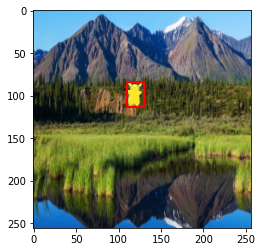

In [ ]:
bbox = labels[0,:,1:].numpy().reshape(4,)

h, w = img[0].shape[1:]
bbox_scale = np.array((w, h, w, h))
fig = plt.imshow(img[0].permute(1,2,0).int())
fig.axes.add_patch(bbox_to_rect(bbox*bbox_scale, 'red'))
plt.show()

In [ ]:
#clean up
del train, test, batch_size, dataiter, img, labels, bbox, h, w, bbox_scale, fig

In [ ]:
def weights_init_xavier(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)

In [ ]:
net = TinySSD(num_classes=1)
net.apply(weights_init_xavier)
net.to(device)

TinySSD(
  (blk_0): Sequential(
    (0): Sequential(
      (c0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b0): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (r0): ReLU()
      (c1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (r1): ReLU()
      (m): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (c0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (r0): ReLU()
      (c1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (r1): ReLU()
      (m): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

## Definine Loss and Evaluation Functions

In [ ]:
cls_loss = nn.CrossEntropyLoss()
bbox_loss = nn.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

In [ ]:
def cls_eval(cls_preds, cls_labels):
    # Because the category prediction results are placed in the final
    # dimension, argmax must specify this dimension
    return (torch.argmax(cls_preds, dim=1) != cls_labels).sum().item()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return (torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum().item()

## Training the Model

In [ ]:
def train(dataloader):
    cls_err = 0
    cls_total = 0
    bbox_mae = 0
    bbox_total = 0
    loss = 0
    for batch, data in enumerate(dataloader):
        X, Y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = get_target(anchors, Y, cls_preds)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        
        loss+=l.cpu().item() #log

        l.backward()
        optimizer.step()

        cls_err += cls_eval(cls_preds, cls_labels)
        cls_total += cls_labels.size(1) * cls_labels.size(0)
        bbox_mae += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        bbox_total += bbox_labels.size(1) * bbox_labels.size(0)

    return cls_err/cls_total, bbox_mae/bbox_total, loss/(batch+1)

In [ ]:
def validate(dataloader):
    cls_err = 0
    cls_total = 0
    bbox_mae = 0
    bbox_total = 0
    loss = 0
    with torch.no_grad():
        for batch, data in enumerate(dataloader):
            X, Y = data[0].to(device), data[1].to(device)
            anchors, cls_preds, bbox_preds = net(X)
            bbox_labels, bbox_masks, cls_labels = get_target(anchors, Y, cls_preds)
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
            
            loss+=l.cpu().item() #log

            cls_err += cls_eval(cls_preds, cls_labels)
            cls_total += cls_labels.size(1) * cls_labels.size(0)
            bbox_mae += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
            bbox_total += bbox_labels.size(1) * bbox_labels.size(0)

    return cls_err/cls_total, bbox_mae/bbox_total, loss/(batch+1)

In [ ]:
num_epochs = 10
optimizer = optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

cls_err_train, bbox_mae_train, loss_train = [None]*num_epochs, [None]*num_epochs, [None]*num_epochs
cls_err_test, bbox_mae_test, loss_test = [None]*num_epochs, [None]*num_epochs, [None]*num_epochs

for epoch in tqdm(range(num_epochs)):
    net.train()
    cls_err_train[epoch], bbox_mae_train[epoch], loss_train[epoch] = train(trainloader)
    cls_err_test[epoch], bbox_mae_test[epoch], loss_test[epoch] = validate(testloader)
    #print(loss_train[epoch], loss_test[epoch])

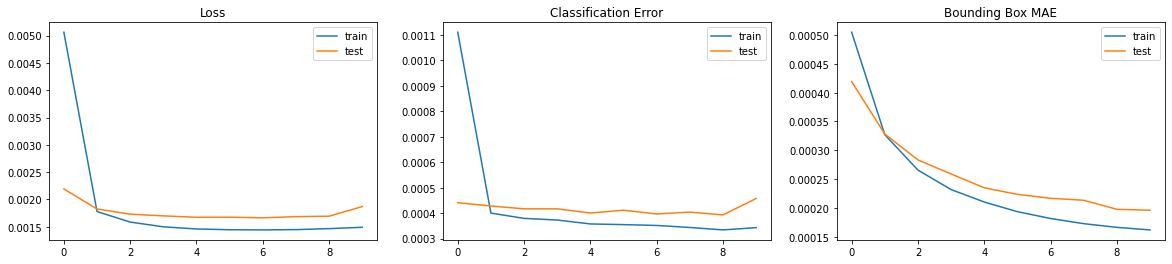

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
ax = ax.flatten()

train_plots = (loss_train, cls_err_train, bbox_mae_train)
test_plots = (loss_test, cls_err_test, bbox_mae_test)
titles = ('Loss', 'Classification Error', 'Bounding Box MAE')

for i in range(3):
    ax[i].plot(train_plots[i], label='train')
    ax[i].plot(test_plots[i], label='test')
    ax[i].set_title(titles[i])
    ax[i].legend()

plt.show()

# Prediction

In [ ]:
img_data = requests.get('https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/pikachu.jpg').content
with open ('pikachu.jpg', 'wb') as img:
    img.write(img_data)

In [ ]:
img = Image.open('pikachu.jpg')
test = tf.to_tensor(img).unsqueeze(0)

In [ ]:
def predict(X):
    #net.eval()
    with torch.no_grad():
        anchors, cls_preds, bbox_preds = net(X.to(device))
        cls_probs = torch.softmax(cls_preds, dim=1)
        output = get_detection(cls_probs, bbox_preds, anchors)
        idx = [i for i, row in enumerate(output[0]) if row[0] !=-1]
        if device.type == 'cuda':
            output = output.cpu().detach().numpy()
        else:
            output = output.detach().numpy()
    return output[0, idx]

In [ ]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (top-left x, top-left y, bottom-right x,
    # bottom-right y) format to matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox, color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [ ]:
def display(img, output, threshold, save=False, filename=None):
    plt.figure(figsize=(6,6))
    img = img.squeeze(0).permute(1,2,0)
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:] * (w, h, w, h)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')
    if save:
        plt.savefig(filename, transparent=True)
    return fig

In [ ]:
output = predict(test)
output.shape

(38, 6)

In [ ]:
alskdfj

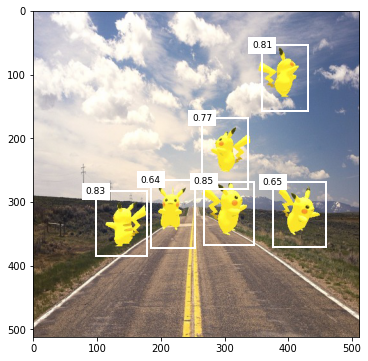

In [ ]:
display(test, output, 0.3, save=True, filename='result.jpg')

# References

https://cv.gluon.ai/build/examples_detection/finetune_detection.html?highlight=pikachu

https://cv.gluon.ai/_modules/gluoncv/utils/download.html#download